In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import PCHazard

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
get_target = lambda df: (df['duration'].values, df['event'].values)

# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))


train = (x_train, y_train)
val = (x_test, y_test)

# We don't need to transform the test labels
time_test, status_test = get_target(df_test)

# Neural Network

In [14]:
in_features = x_train.shape[1]
num_nodes = [16,4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.3
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout)

model_cox = PCHazard(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, val_data =val)


0:	[0s / 0s],		train_loss: 4.2284,	val_loss: 4.3642
1:	[0s / 0s],		train_loss: 3.9860,	val_loss: 4.0221
2:	[0s / 0s],		train_loss: 3.8566,	val_loss: 3.7535
3:	[0s / 0s],		train_loss: 3.5315,	val_loss: 3.5239
4:	[0s / 0s],		train_loss: 3.4248,	val_loss: 3.2844
5:	[0s / 0s],		train_loss: 3.1741,	val_loss: 2.9849
6:	[0s / 0s],		train_loss: 2.9392,	val_loss: 2.6453
7:	[0s / 0s],		train_loss: 2.6271,	val_loss: 2.3369
8:	[0s / 0s],		train_loss: 2.3865,	val_loss: 2.0664
9:	[0s / 0s],		train_loss: 2.2083,	val_loss: 1.8352
10:	[0s / 0s],		train_loss: 2.0226,	val_loss: 1.6448
11:	[0s / 0s],		train_loss: 1.8222,	val_loss: 1.5061
12:	[0s / 0s],		train_loss: 1.6414,	val_loss: 1.4116
13:	[0s / 0s],		train_loss: 1.7406,	val_loss: 1.3574
14:	[0s / 0s],		train_loss: 1.6257,	val_loss: 1.3185
15:	[0s / 0s],		train_loss: 1.5876,	val_loss: 1.2999
16:	[0s / 0s],		train_loss: 1.5618,	val_loss: 1.2869
17:	[0s / 0s],		train_loss: 1.6319,	val_loss: 1.2815
18:	[0s / 0s],		train_loss: 1.5208,	val_loss: 1.2781
19:

0.6528989225243714

<Figure size 864x864 with 0 Axes>

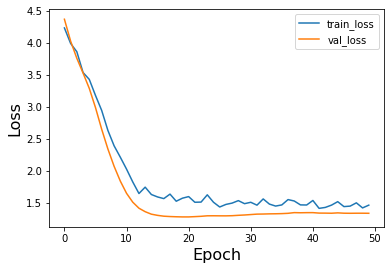

In [15]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.1615096721115481

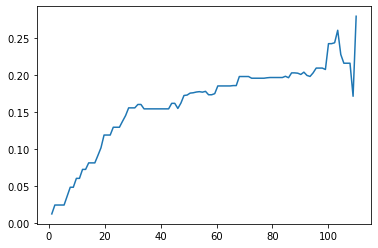

In [16]:
# integrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [17]:
# c-index at  all
time_test0, status_test0 = get_target(df_train)
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6662093899843585

0.16854642351581206

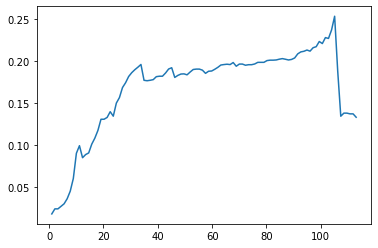

In [18]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

# Save

In [19]:
model_cox.save_model_weights('myweights_PCHazard.pt')

# Bootstrap

In [21]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5498854015899651
The C-index Low 95% CI:0.5493290722286539
The C-index High 95% CI:0.5504417309512764


In [22]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.5357292846584398
The C-index Low 95% CI:0.5352612546529655
The C-index High 95% CI:0.5361973146639142


# LASSO var

In [23]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [24]:
# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


x_train = x_mapper.fit_transform(df_train_lasso).astype('float32')
x_test = x_mapper.transform(df_test_lasso).astype('float32')


train = (x_train, y_train)
val = (x_test, y_test)


In [25]:
in_features = x_train.shape[1]
num_nodes = [16,4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.3
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout)

model_cox = PCHazard(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, val_data =val)


0:	[0s / 0s],		train_loss: 4.2389,	val_loss: 4.3757
1:	[0s / 0s],		train_loss: 3.9721,	val_loss: 3.9753
2:	[0s / 0s],		train_loss: 3.7301,	val_loss: 3.6641
3:	[0s / 0s],		train_loss: 3.4875,	val_loss: 3.3315
4:	[0s / 0s],		train_loss: 3.2484,	val_loss: 3.0830
5:	[0s / 0s],		train_loss: 2.9443,	val_loss: 2.7896
6:	[0s / 0s],		train_loss: 2.7875,	val_loss: 2.5419
7:	[0s / 0s],		train_loss: 2.5514,	val_loss: 2.3425
8:	[0s / 0s],		train_loss: 2.1897,	val_loss: 2.1307
9:	[0s / 0s],		train_loss: 2.1264,	val_loss: 1.8345
10:	[0s / 0s],		train_loss: 1.9488,	val_loss: 1.6534
11:	[0s / 0s],		train_loss: 1.8038,	val_loss: 1.5741
12:	[0s / 0s],		train_loss: 1.7308,	val_loss: 1.5256
13:	[0s / 0s],		train_loss: 1.6390,	val_loss: 1.4888
14:	[0s / 0s],		train_loss: 1.5636,	val_loss: 1.4553
15:	[0s / 0s],		train_loss: 1.5226,	val_loss: 1.4201
16:	[0s / 0s],		train_loss: 1.6638,	val_loss: 1.4071
17:	[0s / 0s],		train_loss: 1.5258,	val_loss: 1.4014
18:	[0s / 0s],		train_loss: 1.5854,	val_loss: 1.3921
19:

0.5913288866085172

<Figure size 864x864 with 0 Axes>

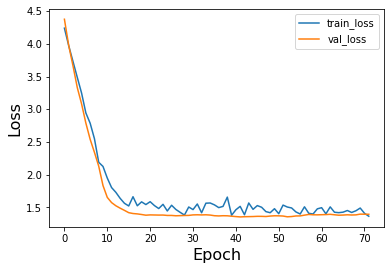

In [26]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.16797572343629316

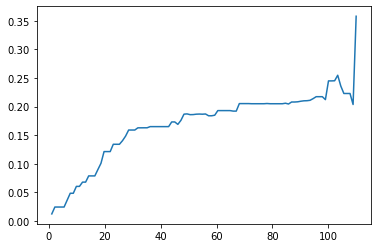

In [27]:
# integrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [28]:
# c-index at  all
time_test0, status_test0 = get_target(df_train)
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6660427190440781

0.16106713080433835

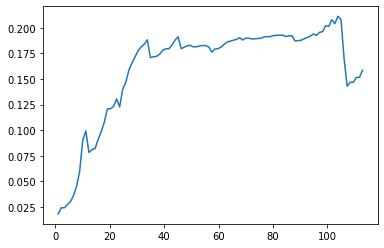

In [29]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [30]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5494919742823205
The C-index Low 95% CI:0.5489185167923665
The C-index High 95% CI:0.5500654317722746


In [31]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.5353263800822459
The C-index Low 95% CI:0.5348662703891756
The C-index High 95% CI:0.5357864897753162


# TNM

In [32]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [33]:
# to standardize and get dependent variables 
cols_leave = ['T', 'N', 'M', 'Stage'] #categorical variables 
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(leave)


x_train = x_mapper.fit_transform(df_train_tnm).astype('float32')
x_test = x_mapper.transform(df_test_tnm).astype('float32')


train = (x_train, y_train)
val = (x_test, y_test)

In [34]:
in_features = x_train.shape[1]
num_nodes = [16,4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.3
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout)

model_cox = PCHazard(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, val_data =val)


0:	[0s / 0s],		train_loss: 3.9729,	val_loss: 3.9053
1:	[0s / 0s],		train_loss: 3.6984,	val_loss: 3.6640
2:	[0s / 0s],		train_loss: 3.4103,	val_loss: 3.3765
3:	[0s / 0s],		train_loss: 3.2327,	val_loss: 3.0771
4:	[0s / 0s],		train_loss: 2.9236,	val_loss: 2.8392
5:	[0s / 0s],		train_loss: 2.7738,	val_loss: 2.5134
6:	[0s / 0s],		train_loss: 2.6237,	val_loss: 2.2892
7:	[0s / 0s],		train_loss: 2.3213,	val_loss: 2.1044
8:	[0s / 0s],		train_loss: 2.2319,	val_loss: 1.8976
9:	[0s / 0s],		train_loss: 2.0613,	val_loss: 1.7307
10:	[0s / 0s],		train_loss: 1.9353,	val_loss: 1.5943
11:	[0s / 0s],		train_loss: 1.8379,	val_loss: 1.5080
12:	[0s / 0s],		train_loss: 1.7094,	val_loss: 1.4502
13:	[0s / 0s],		train_loss: 1.7489,	val_loss: 1.4060
14:	[0s / 0s],		train_loss: 1.5830,	val_loss: 1.3776
15:	[0s / 0s],		train_loss: 1.6457,	val_loss: 1.3596
16:	[0s / 0s],		train_loss: 1.4989,	val_loss: 1.3505
17:	[0s / 0s],		train_loss: 1.5464,	val_loss: 1.3415
18:	[0s / 0s],		train_loss: 1.5228,	val_loss: 1.3386
19:

0.6015905592611596

<Figure size 864x864 with 0 Axes>

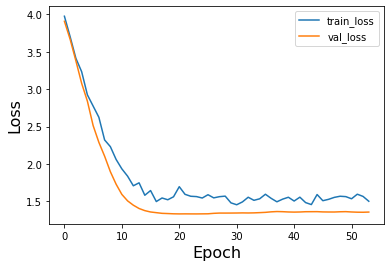

In [35]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.17540631950856447

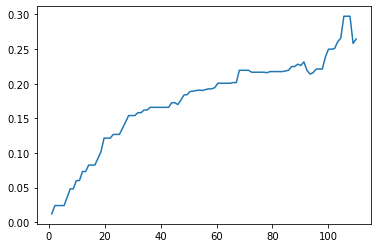

In [36]:
# integrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [37]:
# c-index at  all
time_test0, status_test0 = get_target(df_train)
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6286956075796816

0.18735802038779115

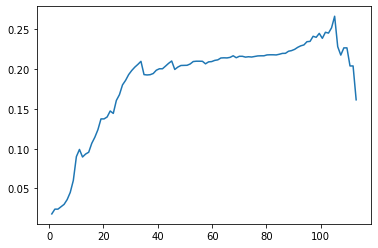

In [38]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [39]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.549424437762352
The C-index Low 95% CI:0.5488594951165648
The C-index High 95% CI:0.549989380408139


In [40]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.5358368737389284
The C-index Low 95% CI:0.5353664907138002
The C-index High 95% CI:0.5363072567640567
